In [1]:
import os
import random
import numpy as np
import pandas as pd
# 导入Paddle的API
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.nn import LSTM, Embedding, Dropout, Linear

from paddlenlp.datasets import load_dataset
from paddlenlp.utils.downloader import get_path_from_url

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
URL = "https://bj.bcebos.com/paddlenlp/datasets/ChnSentiCorp.zip"
# 如果数据集不存在，就下载数据集并解压
if(not os.path.exists('ChnSentiCorp.zip')):
    get_path_from_url(URL,root_dir='.')

In [3]:
def load_imdb_data(path):
    assert os.path.exists(path) 
    trainset, devset, testset = [], [], []

    with open(os.path.join(path, "train.tsv"), "r") as fr:
        for i, line in enumerate(fr):
            if i == 0:  # 跳过第一行
                continue
            sentence_label, sentence = line.strip().lower().split("\t")
            trainset.append((sentence, int(sentence_label)))

    with open(os.path.join(path, "dev.tsv"), "r") as fr:
        for i, line in enumerate(fr):
            if i == 0:  # 跳过第一行
                continue
            sentence_qid, sentence_label, sentence = line.strip().lower().split("\t")
            devset.append((sentence, int(sentence_label)))

    with open(os.path.join(path, "test.tsv"), "r") as fr:
        for i, line in enumerate(fr):
            if i == 0:  # 跳过第一行
                continue
            sentence_qid, sentence = line.strip().lower().split("\t")
            testset.append((sentence, -1))

    return trainset, devset, testset

In [4]:
train_data, dev_data, test_data = load_imdb_data("./ChnSentiCorp/ChnSentiCorp/") 

In [5]:
print("train data length: {}".format(len(train_data)))
print("train data example: ",train_data[1])
print("dev data length: {}".format(len(dev_data)))
print("dev data example: ",dev_data[1])
print("test data length: {}".format(len(test_data)))
print("test data example: ",test_data[1])

train data length: 9600
train data example:  ('15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错', 1)
dev data length: 1200
dev data example:  ('<荐书> 推荐所有喜欢<红楼>的红迷们一定要收藏这本书,要知道当年我听说这本书的时候花很长时间去图书馆找和借都没能如愿,所以这次一看到当当有,马上买了,红迷们也要记得备货哦!', 1)
test data length: 1200
test data example:  ('怀着十分激动的心情放映，可是看着看着发现，在放映完毕后，出现一集米老鼠的动画片！开始还怀疑是不是赠送的个别现象，可是后来发现每张dvd后面都有！真不知道生产商怎么想的，我想看的是猫和老鼠，不是米老鼠！如果厂家是想赠送的话，那就全套米老鼠和唐老鸭都赠送，只在每张dvd后面添加一集算什么？？简直是画蛇添足！！', -1)


In [6]:
from collections import defaultdict
import jieba
from paddlenlp.data import Vocab

# 构建词表
def build_vocab(texts,
                stopwords=[],
                num_words=None,
                min_freq=10,
                unk_token="[UNK]",
                pad_token="[PAD]"):
    word_counts = defaultdict(int)
    for text in texts:
        if not text:
            continue
        # # 统计词频
        # 一般来说，在自然语言处理中，需要先对语料进行切词，英文可以使用空格把每个句子切成若干词的序列
        # 对于中文则需要使用结巴分词进行切分
        for word in jieba.cut(text):
            if word in stopwords:
                continue
            word_counts[word] += 1
    # 过滤掉词频小于min_freq的单词
    wcounts = []
    for word, count in word_counts.items():
        if count < min_freq:
            continue
        wcounts.append((word, count))
    # 把单词按照词频从大到小进行排序
    wcounts.sort(key=lambda x: x[1], reverse=True)
    # 把对齐的字符和unk字符加入到词表中
    if num_words is not None and len(wcounts) > (num_words - 2):
        wcounts = wcounts[:(num_words - 2)]
    # pad字符和unk字符
    sorted_voc = [pad_token, unk_token]
    sorted_voc.extend(wc[0] for wc in wcounts)
    # 给每个单词一个编号
    word_index = dict(zip(sorted_voc, list(range(len(sorted_voc)))))
    return word_index

In [7]:
texts = []
for data in train_data:
    texts.append(data[0])
for data in dev_data:
    texts.append(data[0])
print(len(texts))
print(texts[:5])

10800
['选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', '15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错', '房间太小。其他的都一般。。。。。。。。。', '1.接电源没有几分钟,电源适配器热的不行. 2.摄像头用不起来. 3.机盖的钢琴漆，手不能摸，一摸一个印. 4.硬盘分区不好办.', '今天才知道这书还有第6卷,真有点郁闷:为什么同一套书有两种版本呢?当当网是不是该跟出版社商量商量,单独出个第6卷,让我们的孩子不会有所遗憾。']


In [8]:
# 以下停用词仅用作示例，具体停用词的选择需要根据具体语料库调整。
stopwords = set(["的", "吗", "吧", "呀", "呜", "呢", "呗"])
# 构建词汇表
word2idx = build_vocab(
    texts, stopwords, min_freq=5, unk_token="[UNK]", pad_token="[PAD]")
print(list(word2idx.items())[:10])

Building prefix dict from the default dictionary ...
[2024-06-20 02:48:04,550] [   DEBUG] __init__.py:113 - Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
[2024-06-20 02:48:04,551] [   DEBUG] __init__.py:132 - Loading model from cache /tmp/jieba.cache
Loading model cost 0.887 seconds.
[2024-06-20 02:48:05,438] [   DEBUG] __init__.py:164 - Loading model cost 0.887 seconds.
Prefix dict has been built successfully.
[2024-06-20 02:48:05,440] [   DEBUG] __init__.py:166 - Prefix dict has been built successfully.


[('[PAD]', 0), ('[UNK]', 1), ('，', 2), ('。', 3), ('了', 4), (' ', 5), ('是', 6), (',', 7), ('我', 8), ('很', 9)]


In [9]:
vocab = Vocab.from_dict(word2idx, unk_token="[UNK]", pad_token="[PAD]")
# 保存词汇表
res=vocab.to_json("./vocab.json")

In [10]:
from paddlenlp.data import JiebaTokenizer

def get_idx_from_word(word, word_to_idx, unk_word):
    if word in word_to_idx:
        return word_to_idx[word]
    return word_to_idx[unk_word]

# 把词汇表加载到结巴分词器中
# JiebaTokenizer的encode的作用就是对文本进行分词，然后根据词汇表把文本转换成id的形式。
tokenizer = JiebaTokenizer(vocab)
text='选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。'
segment_text=tokenizer.cut(text)
print("分词后的文本:{}".format(segment_text))
input_ids = [get_idx_from_word(word,vocab.token_to_idx,vocab.unk_token) for word in segment_text]
print("把分词后的文本转换成id:{}".format(input_ids))

input_ids = tokenizer.encode(text)
print("encode 编码后的id: {}".format(input_ids))

分词后的文本:['选择', '珠江', '花园', '的', '原因', '就是', '方便', '，', '有', '电动', '扶梯', '直接', '到达', '海边', '，', '周围', '餐馆', '、', '食廊', '、', '商', '场', '、', '超市', '、', '摊位', '一应', '俱全', '。']
把分词后的文本转换成id:[198, 1, 1603, 1, 407, 38, 105, 2, 16, 1, 1, 350, 989, 1706, 2, 663, 3102, 26, 1, 26, 1, 6202, 26, 1459, 26, 1, 1, 1, 3]
encode 编码后的id: [198, 1, 1603, 1, 407, 38, 105, 2, 16, 1, 1, 350, 989, 1706, 2, 663, 3102, 26, 1, 26, 1, 6202, 26, 1459, 26, 1, 1, 1, 3]


In [11]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset

class IMDBDataset(Dataset):
    def __init__(self, examples, word2id_dict):
        super(IMDBDataset, self).__init__()
        self.word2id_dict = word2id_dict
        self.examples = self.words_to_id(examples)

    def words_to_id(self, examples):
        tmp_examples = []
        for idx, example in enumerate(examples):
            seq, label = example
            segment_seq = tokenizer.cut(seq)
            seq = [get_idx_from_word(word,self.word2id_dict.token_to_idx, self.word2id_dict.unk_token) for word in segment_seq]
            tmp_examples.append([seq, label])
        return tmp_examples

    def __getitem__(self, idx):
        seq, label = self.examples[idx]
        return seq, label 

    def __len__(self):
        return len(self.examples)

In [12]:
train_set = IMDBDataset(train_data, vocab)
dev_set = IMDBDataset(dev_data, vocab)
test_set = IMDBDataset(test_data, vocab)

In [13]:
print("train data:")
print(train_data[1])
print(train_set[1])
print("\ndev data:")
print(dev_data[1])
print(dev_set[1])
print("\ntest data:")
print(test_data[1])
print(test_set[1])

train data:
('15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错', 1)
([601, 18, 130, 1, 1, 1, 182, 1, 2, 343, 231, 1, 1, 8408, 4, 2, 744, 58, 3224, 88, 182, 2, 1, 3224, 2247, 105, 2, 540, 11, 9, 2309, 2, 305, 11, 370, 25], 1)

dev data:
('<荐书> 推荐所有喜欢<红楼>的红迷们一定要收藏这本书,要知道当年我听说这本书的时候花很长时间去图书馆找和借都没能如愿,所以这次一看到当当有,马上买了,红迷们也要记得备货哦!', 1)
([1051, 2687, 45, 912, 5, 178, 329, 1, 1, 1051, 7475, 912, 1, 1, 257, 3639, 5733, 466, 45, 7, 40, 72, 2459, 8, 932, 466, 45, 1, 73, 643, 3000, 159, 42, 3437, 195, 23, 2508, 15, 4644, 1, 7, 118, 308, 703, 32, 303, 16, 7, 659, 41, 4, 7, 1, 11, 40, 1004, 1, 638, 59], 1)

test data:
('怀着十分激动的心情放映，可是看着看着发现，在放映完毕后，出现一集米老鼠的动画片！开始还怀疑是不是赠送的个别现象，可是后来发现每张dvd后面都有！真不知道生产商怎么想的，我想看的是猫和老鼠，不是米老鼠！如果厂家是想赠送的话，那就全套米老鼠和唐老鸭都赠送，只在每张dvd后面添加一集算什么？？简直是画蛇添足！！', -1)
([1, 115, 634, 4252, 1, 612, 1, 2, 247, 513, 513, 123, 2, 12, 1, 3317, 71, 2, 531, 8866, 1365, 3348, 1, 6315, 10, 211, 20, 957, 6, 62, 1171, 1, 3157, 1437, 2, 247, 233, 123, 1, 1683, 681, 15, 16, 10, 431, 438, 1058, 1, 

In [20]:
from functools import partial 

def collate_fn(batch_data, pad_val=0, max_seq_len=256):
    seqs, seq_lens, labels = [], [], []
    max_len = 0
    for example in batch_data:
        seq, label = example 
        seq = seq[:max_seq_len]
        seqs.append(seq)
        seq_lens.append(len(seq))
        labels.append(label)
        max_len = max(max_len, len(seq))
    for i in range(len(seqs)):
        seqs[i] = seqs[i] + [pad_val] * (max_len - len(seqs[i]))
    return (paddle.to_tensor(seqs), paddle.to_tensor(seq_lens)), paddle.to_tensor(labels)

In [21]:
from paddle import io

max_seq_len = 256
batch_size = 128
collate_fn = partial(collate_fn, pad_val=0, max_seq_len=max_seq_len)
train_loader = io.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False, collate_fn=collate_fn)
dev_loader = io.DataLoader(dev_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)
test_loader = io.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)

In [23]:
class AveragePooling(nn.Layer):
    def __init__(self):
        super(AveragePooling, self).__init__()

    def forward(self, sequence_output, sequence_length):
        sequence_length = paddle.cast(sequence_length.unsqueeze(-1), dtype="float32")
        max_len = sequence_output.shape[1]
        mask = paddle.arange(max_len) < sequence_length 
        mask = paddle.cast(mask, dtype='float32').unsqueeze(-1)
        sequence_output = paddle.multiply(sequence_output, mask)
        batch_mean_hidden = paddle.divide(paddle.sum(sequence_output, axis=1), sequence_length)
        return batch_mean_hidden

In [17]:
class Model_BiLSTM_FC(nn.Layer):
    def __init__(self, num_embeddings, input_size, hidden_size, num_classes=2):
        super(Model_BiLSTM_FC, self).__init__()
        self.num_embeddings = num_embeddings
        self.inout_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.embedding_layer = nn.Embedding(num_embeddings, input_size, padding_idx=0)
        self.lstm_layer = nn.LSTM(input_size, hidden_size, direction="bidirectional")
        self.average_layer = AveragePooling()
        self.output_layer = nn.Linear(hidden_size*2, num_classes)

    def forward(self, inputs):
        input_ids, sequence_length = inputs
        inputs_emb = self.embedding_layer(input_ids)
        sequence_output, _ = self.lstm_layer(inputs_emb, sequence_length=sequence_length)
        batch_mean_hidden = self.average_layer(sequence_output, sequence_length)
        logits = self.output_layer(batch_mean_hidden)
        return logits

In [24]:
from nndl import Accuracy, RunnerV3

num_embeddings = len(vocab)
input_size = 256
hidden_size = 256
model = Model_BiLSTM_FC(num_embeddings, input_size, hidden_size)
optimizer = paddle.optimizer.Adam(learning_rate=0.001, beta1=0.9, beta2=0.999, parameters=model.parameters())
loss_fn = nn.CrossEntropyLoss()
metric = Accuracy()
runner = RunnerV3(model, optimizer, loss_fn, metric)
runner.train(train_loader, dev_loader, num_epochs=5, eval_steps=10, log_steps=10, save_path="./checkpoints/best.pdparams")

[Train] epoch: 0/5, step: 0/375, loss: 0.69321
[Train] epoch: 0/5, step: 10/375, loss: 0.67800
[Evaluate]  dev score: 0.74667, dev loss: 0.67704
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.74667
[Train] epoch: 0/5, step: 20/375, loss: 0.54345
[Evaluate]  dev score: 0.74917, dev loss: 0.51452
[Evaluate] best accuracy performence has been updated: 0.74667 --> 0.74917
[Train] epoch: 0/5, step: 30/375, loss: 0.44459
[Evaluate]  dev score: 0.83917, dev loss: 0.36812
[Evaluate] best accuracy performence has been updated: 0.74917 --> 0.83917
[Train] epoch: 0/5, step: 40/375, loss: 0.31414
[Evaluate]  dev score: 0.86417, dev loss: 0.33032
[Evaluate] best accuracy performence has been updated: 0.83917 --> 0.86417
[Train] epoch: 0/5, step: 50/375, loss: 0.29653
[Evaluate]  dev score: 0.87833, dev loss: 0.30288
[Evaluate] best accuracy performence has been updated: 0.86417 --> 0.87833
[Train] epoch: 0/5, step: 60/375, loss: 0.28413
[Evaluate]  dev score: 0.87667, dev loss

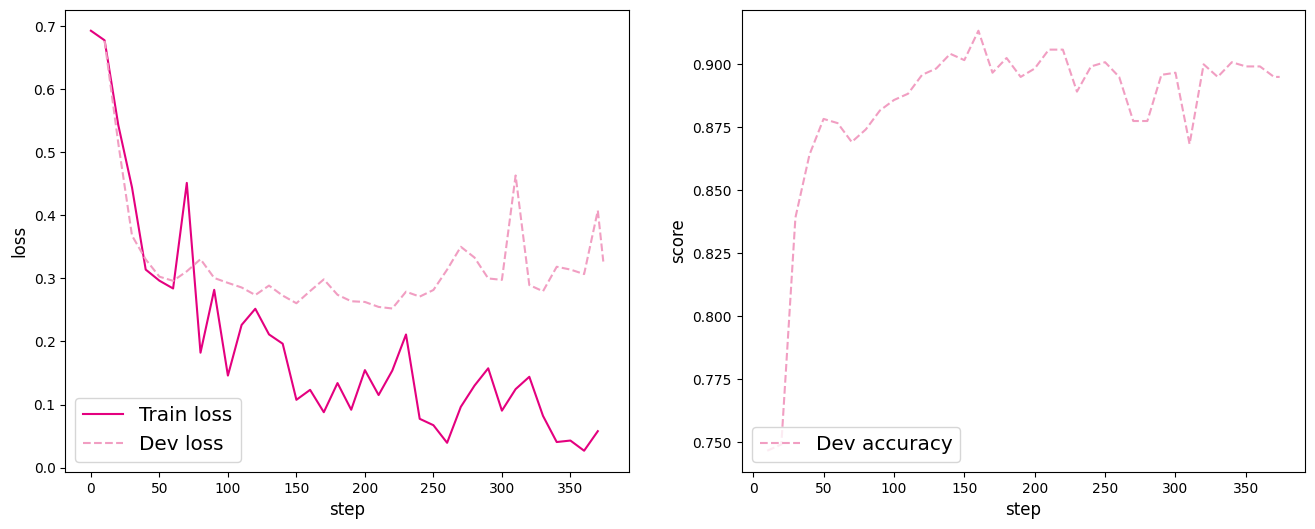

In [25]:
from nndl import plot_training_loss_acc

plot_training_loss_acc(runner=runner, fig_name="training_loss_acc.pdf")

In [37]:
id2label = {0:"差评", 1:"好评"}
text = test_data[5][0]
print("评论：",text)
segment_text=tokenizer.cut(text)
tokens = [get_idx_from_word(word,vocab.token_to_idx,vocab.unk_token) for word in segment_text]
tokens = tokens[:max_seq_len]
sequence_length = paddle.to_tensor([len(tokens)], dtype="int64")
tokens = paddle.to_tensor(tokens, dtype="int64").unsqueeze(0)
logits = runner.predict((tokens, sequence_length))
max_label_id = paddle.argmax(logits, axis=-1).numpy()[0]
pred_label = id2label[max_label_id]
print("\n判定：",pred_label)

评论： 有了第一本书的铺垫，读第二本的时候开始进入状态。基本上第二本就围绕主角们的能力训练展开，故事的主要发生场地设置在美洲的亚马逊丛林。心里一直疑惑这和西藏有什么关系，不过大概看完全书才能知道内里的线索。其中描述了很多热带雨林中特有的神秘动植物以及一些生存技巧和常识，受益匪浅。能够想像出要写这样一部书，融合这样许多的知识，作者需要花费多少心血来搜集和整理并成文。

判定： 好评
